# Fixed order testing

In this notebook, we test out the fixed order setting of our flow model. With a fixed ordering, the true ordering should produce the best likelihood compared to the rest. This is a first step to test out before we move on to learn the ordering itself.

In [22]:
import sys
sys.path.append('../')
import torch
import matplotlib.pyplot as plt
from notebook_setup import device
from ocd.models.oslow import OSlow
from ocd.data.synthetic.graph_generator import GraphGenerator
from ocd.data.synthetic.utils import RandomGenerator
from ocd.data.synthetic.parametric import AffineParametericDataset
from ocd.data.synthetic.nonparametric import AffineNonParametericDataset
from ocd.models.normalization import ActNorm

# Function to smooth the loss graphs
def smooth_graph(histories, window_size=100):
    smoothed = {}
    for key, history in histories.items():
        smoothed[key] = []
        for i in range(window_size, len(history)):
            smoothed[key].append(sum(history[max(0, i - window_size) : i + 1])/window_size)
    return smoothed

%load_ext autoreload
%autoreload 2
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [23]:
def create_new_set_of_models(
    additive = False,
    num_transforms = 1,
    normalization = ActNorm,
    base_distribution = torch.distributions.Normal(loc=0, scale=1),
    use_standard_ordering = False,
):
    all_models = {
        '012': None,
        '021': None,
        '102': None,
        '120': None,
        '201': None,
        '210': None,
    }

    for ordering in all_models.keys():
        order = [int(x) for x in ordering]
        all_models[ordering] = OSlow(
            in_features=3,
            layers=[100, 100],
            dropout=None,
            residual=False,
            activation=torch.nn.LeakyReLU(),
            additive=additive,
            num_transforms=num_transforms,
            normalization=normalization,
            base_distribution=base_distribution,
            ordering=None if use_standard_ordering else torch.IntTensor(order),
        )
    
    return all_models
    


In [25]:
# create a torch dataset and dataloader from dset.samples
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

def train_models_and_get_histories(
    all_models, 
    dset, 
    batch_size=128, 
    lr=0.005, 
    epoch_count=100,
    use_standard_ordering = False,
):
        
    tensor_samples = torch.tensor(dset.samples.values).float()
    torch_dataset = TensorDataset(tensor_samples)
    torch_dataloader = DataLoader(torch_dataset, batch_size=batch_size, shuffle=True)

    all_histories_laplace = {}
    for key, model in all_models.items():
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        all_histories_laplace[key] = []
        progress_bar = tqdm(range(epoch_count), desc="training model {}".format(key))

        for epoch in progress_bar:
            for batch, in torch_dataloader:
                batch = batch.to(device)
                if not use_standard_ordering:
                    loss = -model.log_prob(batch).mean()
                else:
                    order = [int(x) for x in key]
                    # create a permutation matrix from the order
                    permutation_matrix = torch.zeros((3, 3))
                    for i, j in enumerate(order):
                        permutation_matrix[i, j] = 1
                    loss = -model.log_prob(batch, perm_mat=permutation_matrix).mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                all_histories_laplace[key].append(loss.item())
    
    return all_histories_laplace

## Synthetic Data Generation


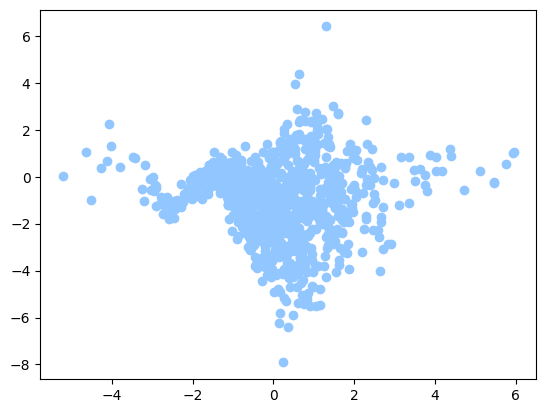

In [33]:

graph_generator = GraphGenerator(
    num_nodes=3,
    seed=0,
    graph_type="full",
    enforce_ordering=[1, 0, 2],
)
graph = graph_generator.generate_dag()

gaussian_noise_generator = RandomGenerator('normal', seed=10, loc=0, scale=1)
laplace_noise_generator = RandomGenerator('laplace', seed=10, loc=0, scale=1)
link_generator = RandomGenerator('uniform', seed=110, low=1, high=1)


num_samples = 10000
dset_sinusoidal = AffineParametericDataset(
    num_samples=num_samples,
    graph=graph,
    noise_generator=gaussian_noise_generator,
    link_generator=link_generator,
    link="sinusoid",
    perform_normalization=False,
)
dset_cubic = AffineParametericDataset(
    num_samples=num_samples,
    graph=graph,
    noise_generator=gaussian_noise_generator,
    link_generator=link_generator,
    link="cubic",
    perform_normalization=True,
)
dset_laplace_linear = AffineParametericDataset(
    num_samples=num_samples,
    graph=graph,
    noise_generator=laplace_noise_generator,
    link_generator=link_generator,
    link="linear",
    perform_normalization=False,
    additive=True,
)

dset_nonparametric = AffineNonParametericDataset(
    num_samples=1000,
    graph=graph,
    noise_generator=gaussian_noise_generator,
    invertibility_coefficient=0.0,
    perform_normalization=False,
    additive=False,
)
plt.scatter(
    dset_nonparametric.samples[1].values,
    dset_nonparametric.samples[0].values,
)
plt.show()


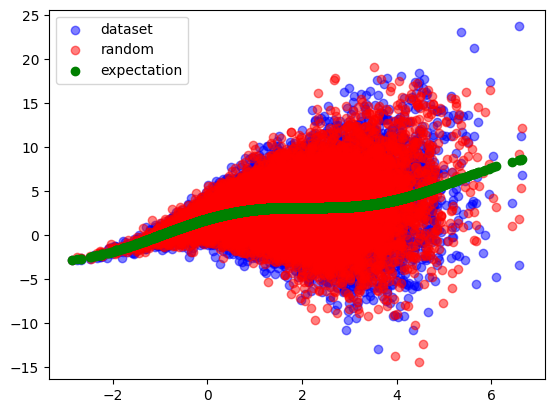

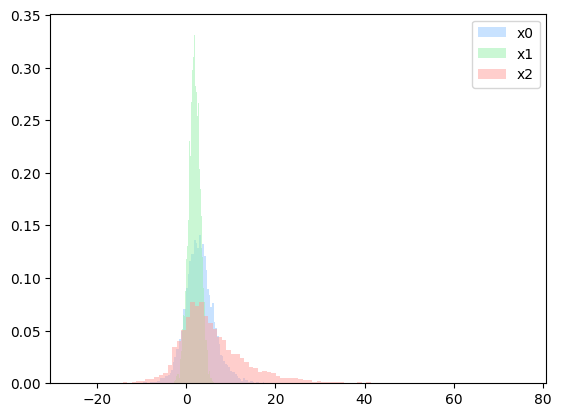

In [3]:
import numpy as np
first_col = 1
second_col = 0
# plot the first column of dset.samples against the second column
plt.scatter(dset_sinusoidal.samples[first_col].values, dset_sinusoidal.samples[second_col].values, alpha=0.5, color='blue', label='dataset')
pre = dset_sinusoidal.samples[first_col].values + 1
plt.scatter(dset_sinusoidal.samples[first_col].values, np.sin(pre) + pre + np.log(1 + np.exp(pre)) * gaussian_noise_generator(num_samples), color='red', alpha=0.5, label='random')
plt.scatter(dset_sinusoidal.samples[first_col].values, np.sin(pre) + pre, color='green', label='expectation')
plt.legend()
plt.show()

plt.hist(dset_sinusoidal.samples[0].values, bins=100, density=True, alpha=0.5, label='x0')
plt.hist(dset_sinusoidal.samples[1].values, bins=100, density=True, alpha=0.5, label='x1')
plt.hist(dset_sinusoidal.samples[2].values, bins=100, density=True, alpha=0.5, label='x2')
plt.legend()
plt.show()

## Model Training (Nonparametric)

In [34]:
all_models_nonparametric = create_new_set_of_models(
    additive = False,
    num_transforms = 1,
    normalization = ActNorm,
    base_distribution = torch.distributions.Normal(loc=0, scale=1),
)
all_histories_non_parametric = train_models_and_get_histories(
    all_models_nonparametric, 
    dset_nonparametric, 
    batch_size=128, 
    lr=0.005, 
    epoch_count=100,
)


training model 210: 100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


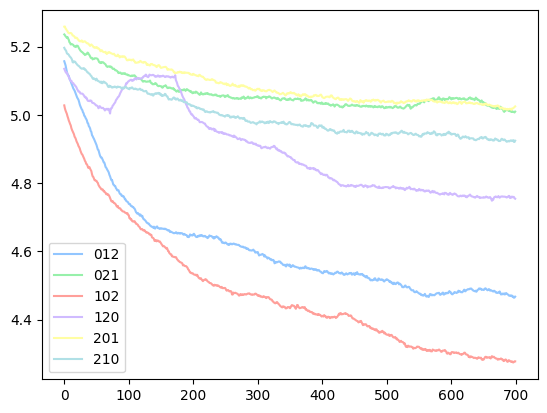

In [35]:
smoothed_histories = smooth_graph(all_histories_non_parametric, window_size=100)
for key in all_histories_non_parametric.keys():
    plt.plot(smoothed_histories[key][:], label=key)
plt.legend()
plt.show()

## Model Training (Laplace linear)

In [4]:
all_models_laplace = {
    '012': None,
    '021': None,
    '102': None,
    '120': None,
    '201': None,
    '210': None,
}

for ordering in all_models_laplace.keys():
    order = [int(x) for x in ordering]
    all_models_laplace[ordering] = OSlow(
        in_features=3,
        layers=[100, 100],
        dropout=None,
        residual=False,
        activation=torch.nn.LeakyReLU(),
        additive=True,
        num_transforms=1,
        # TODO: fix this
        normalization=None,
        base_distribution=torch.distributions.Laplace(loc=0, scale=1),
        ordering=torch.IntTensor(order),
    )
  

training model 210: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


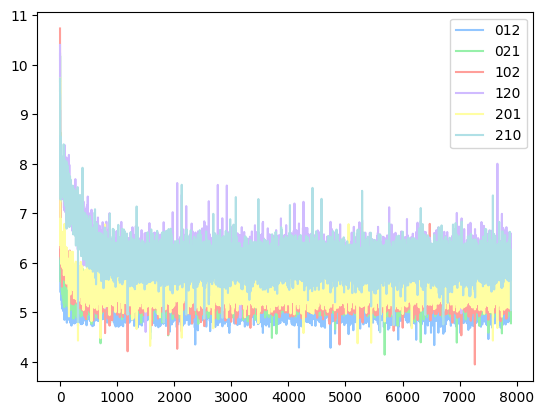

In [5]:
# create a torch dataset and dataloader from dset.samples
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
tensor_samples = torch.tensor(dset_laplace_linear.samples.values).float()
torch_dataset = TensorDataset(tensor_samples)
torch_dataloader = DataLoader(torch_dataset, batch_size=128, shuffle=True)

epoch_count = 100
all_histories_laplace = {}
for key, model in all_models_laplace.items():
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    all_histories_laplace[key] = []
    progress_bar = tqdm(range(epoch_count), desc="training model {}".format(key))

    for epoch in progress_bar:
        for batch, in torch_dataloader:
            batch = batch.to(device)
            loss = -model.log_prob(batch).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            all_histories_laplace[key].append(loss.item())
    plt.plot(all_histories_laplace[key], label=key)
plt.legend()
plt.show()

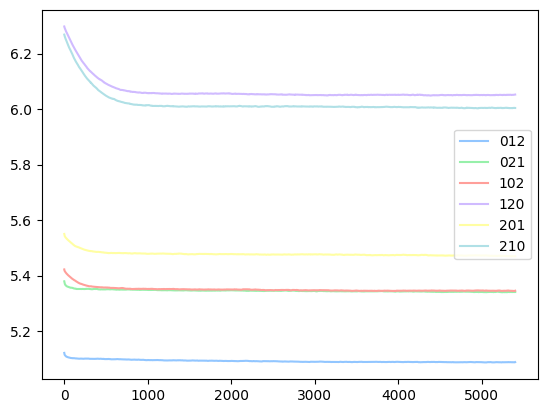

In [6]:
smoothed_histories = smooth_graph(all_histories_laplace, window_size=2500)
for key in all_histories_laplace.keys():
    plt.plot(smoothed_histories[key][:], label=key)
plt.legend()
plt.show()

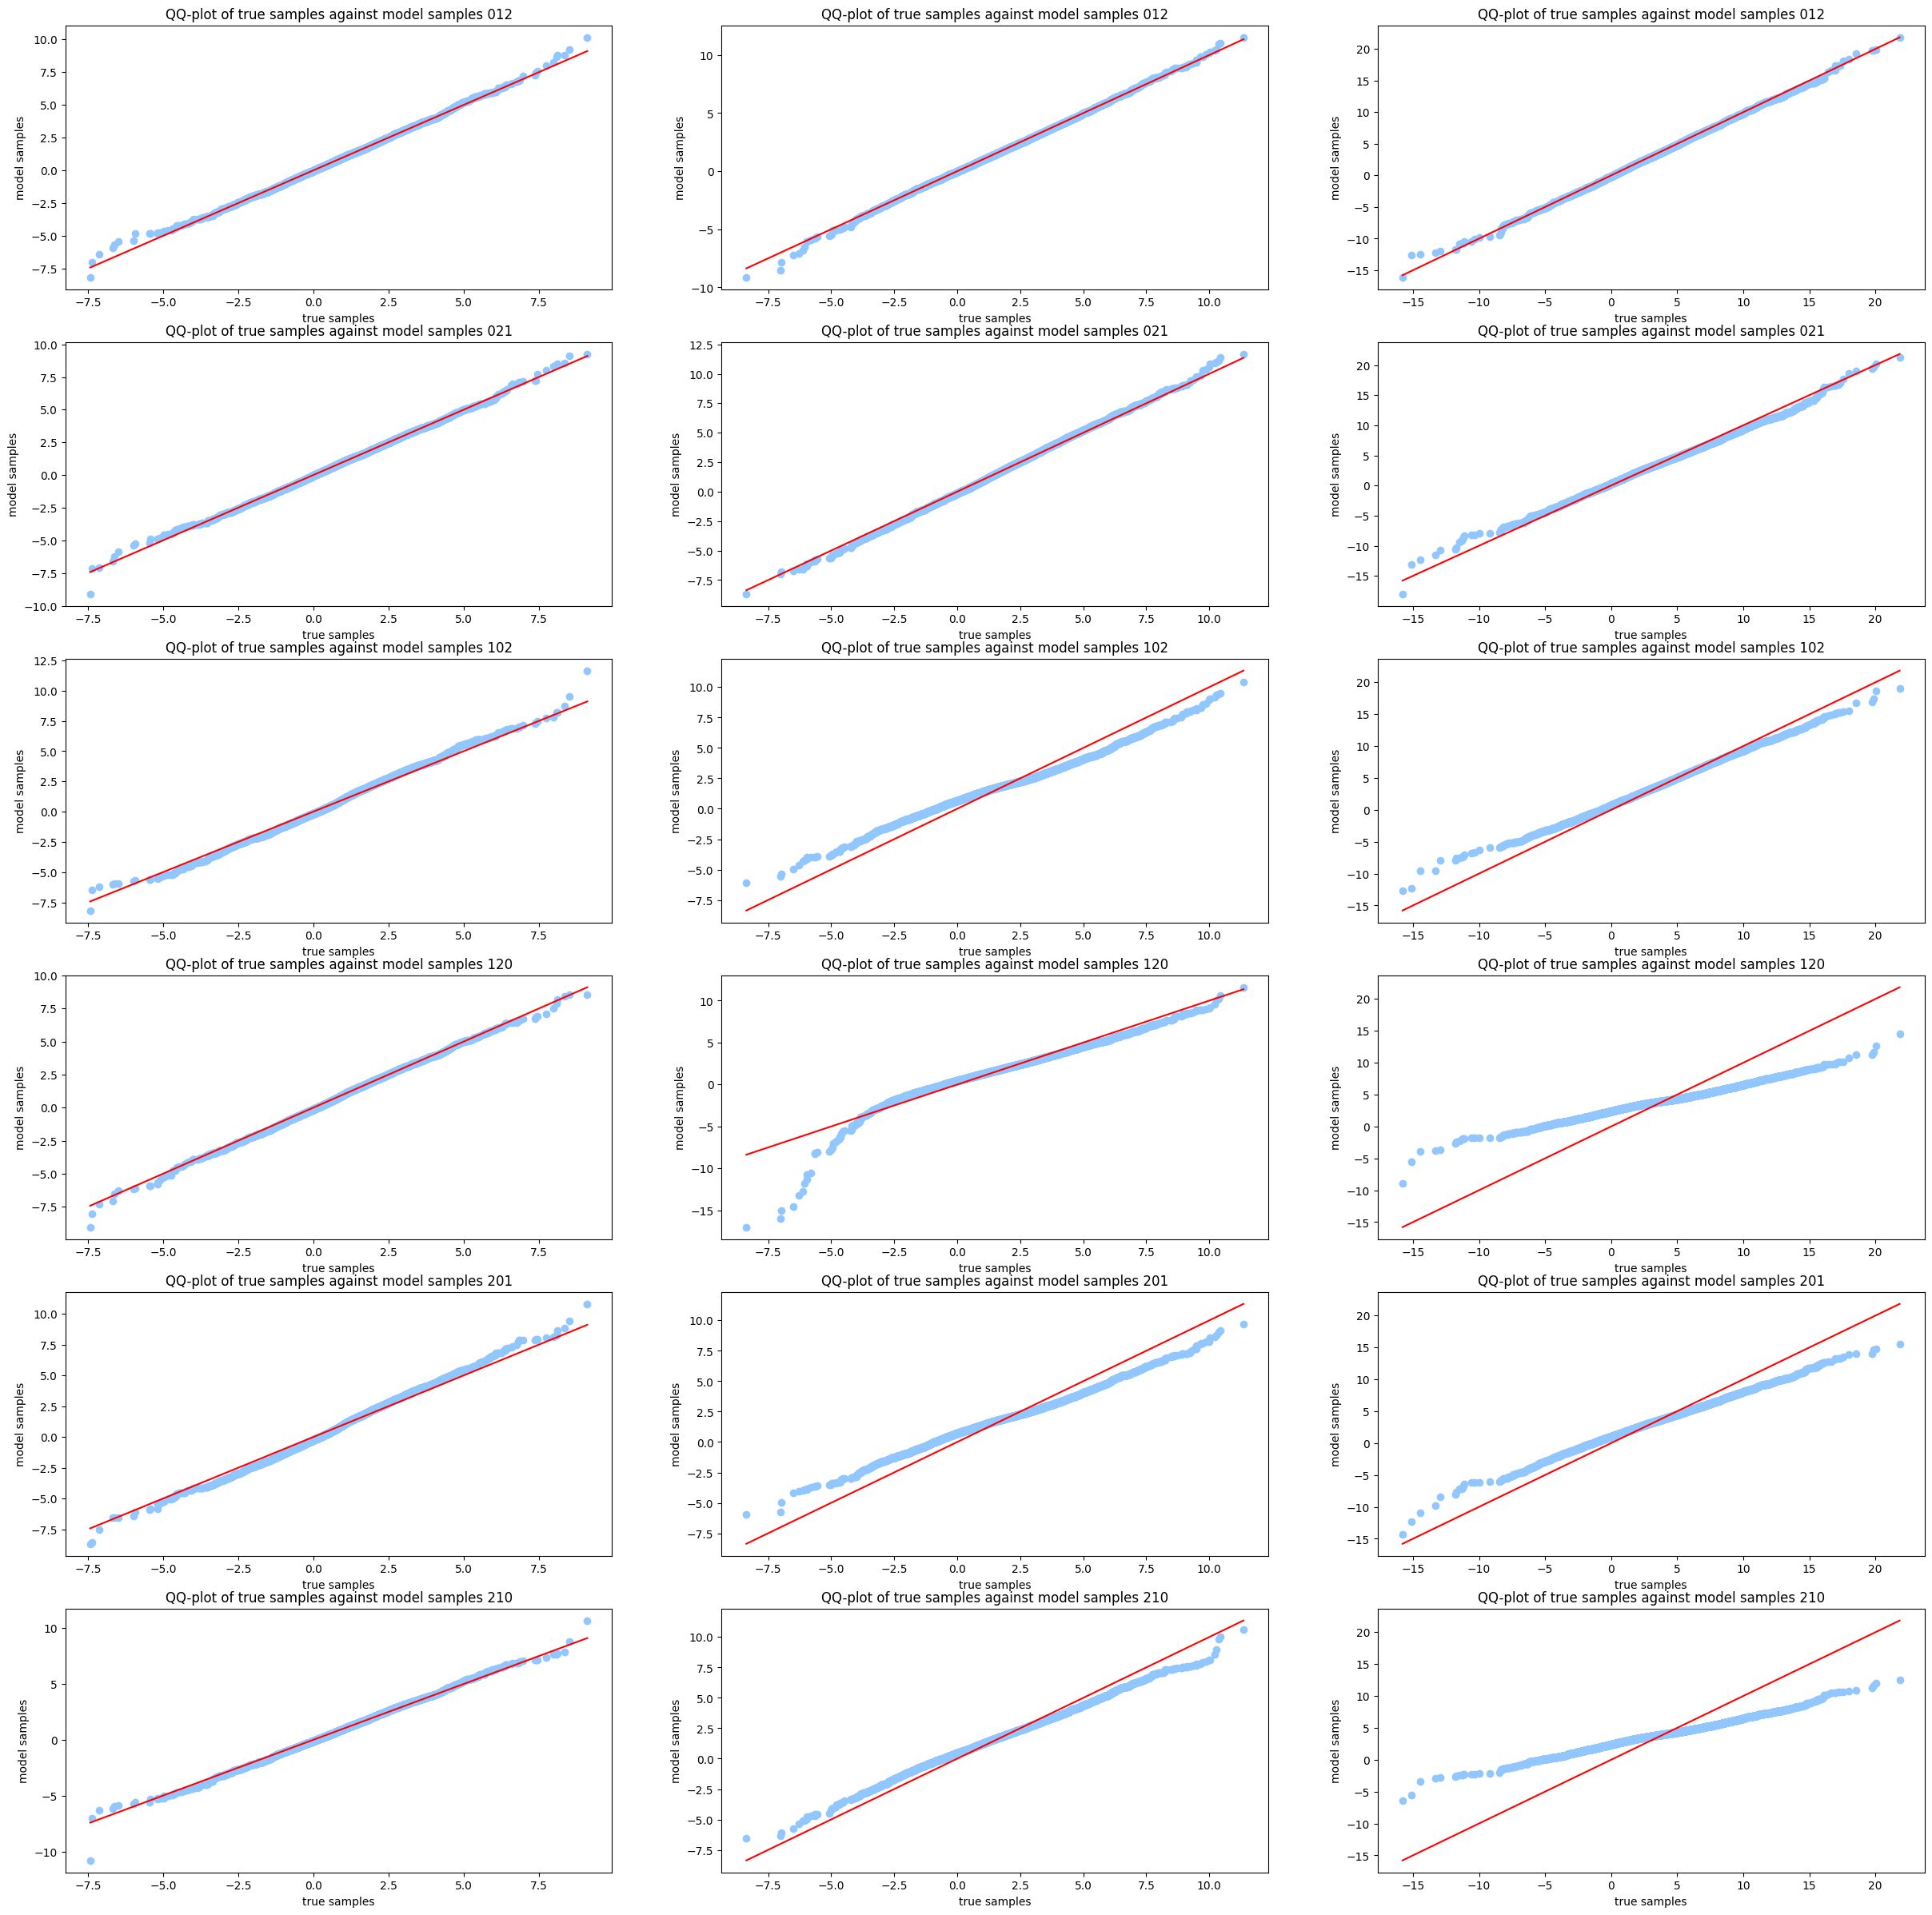

In [7]:
# create a figure with 18 subplots with 6 rows and 3 columns
fig, axs = plt.subplots(6, 3, figsize=(30, 30))
# iterate over the rows
i = 0
for key, model in all_models_laplace.items():
    model.eval()
    with torch.no_grad():
        model_samples = []
        for _ in range(100):
            model_samples.append(model.sample(100).cpu().numpy())
        model_samples = np.concatenate(model_samples)
        # iterate over the columns
        for j in range(3):
            true_samples = dset_laplace_linear.samples[j].values
            # create a qqplot of the true samples against the model samples by first sorting them
            model_samples_sorted = np.sort(model_samples[:, j])
            true_samples_sorted = np.sort(true_samples)
            axs[i, j].scatter(true_samples_sorted, model_samples_sorted, label="qqplot")
            # add title and x_label and y_label to the plot
            axs[i, j].set_title(f"QQ-plot of true samples against model samples {key}")
            axs[i, j].set_xlabel("true samples")
            axs[i, j].set_ylabel("model samples")
            # add an identity line to the plot
            axs[i, j].plot(
                [min(true_samples_sorted), max(true_samples_sorted)],
                [min(true_samples_sorted), max(true_samples_sorted)],
                label="identity",
                color='red'
            )
    i += 1
plt.show()

## Model Training (Sinusoidal)

Instantiate different models with different orders, train them and monitor their loss function.

In [24]:
all_models = {
    '012': None,
    '021': None,
    '102': None,
    '120': None,
    '201': None,
    '210': None,
}

for ordering in all_models.keys():
    order = [int(x) for x in ordering]
    all_models[ordering] = OSlow(
        in_features=3,
        layers=[10, 20, 10],
        dropout=None,
        residual=False,
        activation=torch.nn.LeakyReLU(),
        additive=False,
        num_transforms=1,
        # TODO: fix this
        normalization=ActNorm,
        base_distribution=torch.distributions.Normal(loc=0, scale=1),
        ordering=None,
    )
  

training model 012:   0%|          | 0/33 [00:00<?, ?it/s]

training model 210: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s]


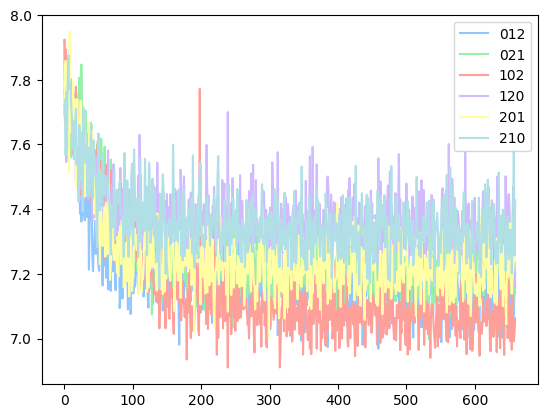

In [25]:
# create a torch dataset and dataloader from dset.samples
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
tensor_samples = torch.tensor(dset_sinusoidal.samples.values).float()
torch_dataset = TensorDataset(tensor_samples)
torch_dataloader = DataLoader(torch_dataset, batch_size=512, shuffle=True)

epoch_count = 33
all_histories = {}
for key, model in all_models.items():
    
    order = [int(x) for x in key]
    # create a permutation matrix from the order
    permutation_matrix = torch.zeros((3, 3))
    for i, j in enumerate(order):
        permutation_matrix[i, j] = 1
    
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)

    all_histories[key] = []
    progress_bar = tqdm(range(epoch_count), desc="training model {}".format(key))

    for epoch in progress_bar:
        for batch, in torch_dataloader:
            batch = batch.to(device)
            loss = -model.log_prob(batch, perm_mat=permutation_matrix).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            all_histories[key].append(loss.item())
    plt.plot(all_histories[key], label=key)
plt.legend()
plt.show()

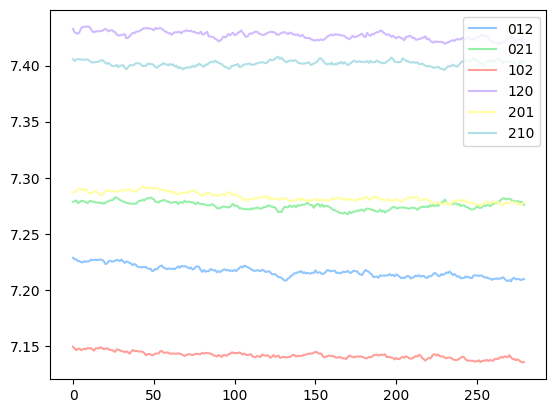

In [26]:
smoothed_histories = smooth_graph(all_histories, window_size=100)
for key in all_histories.keys():
    plt.plot(smoothed_histories[key][len(smoothed_histories[key])//2:], label=key)
plt.legend()
plt.show()

**Sampling check**: We draw samples from the flow model and compare the marginals to the true marginals by creating a qqplot for each dimension.

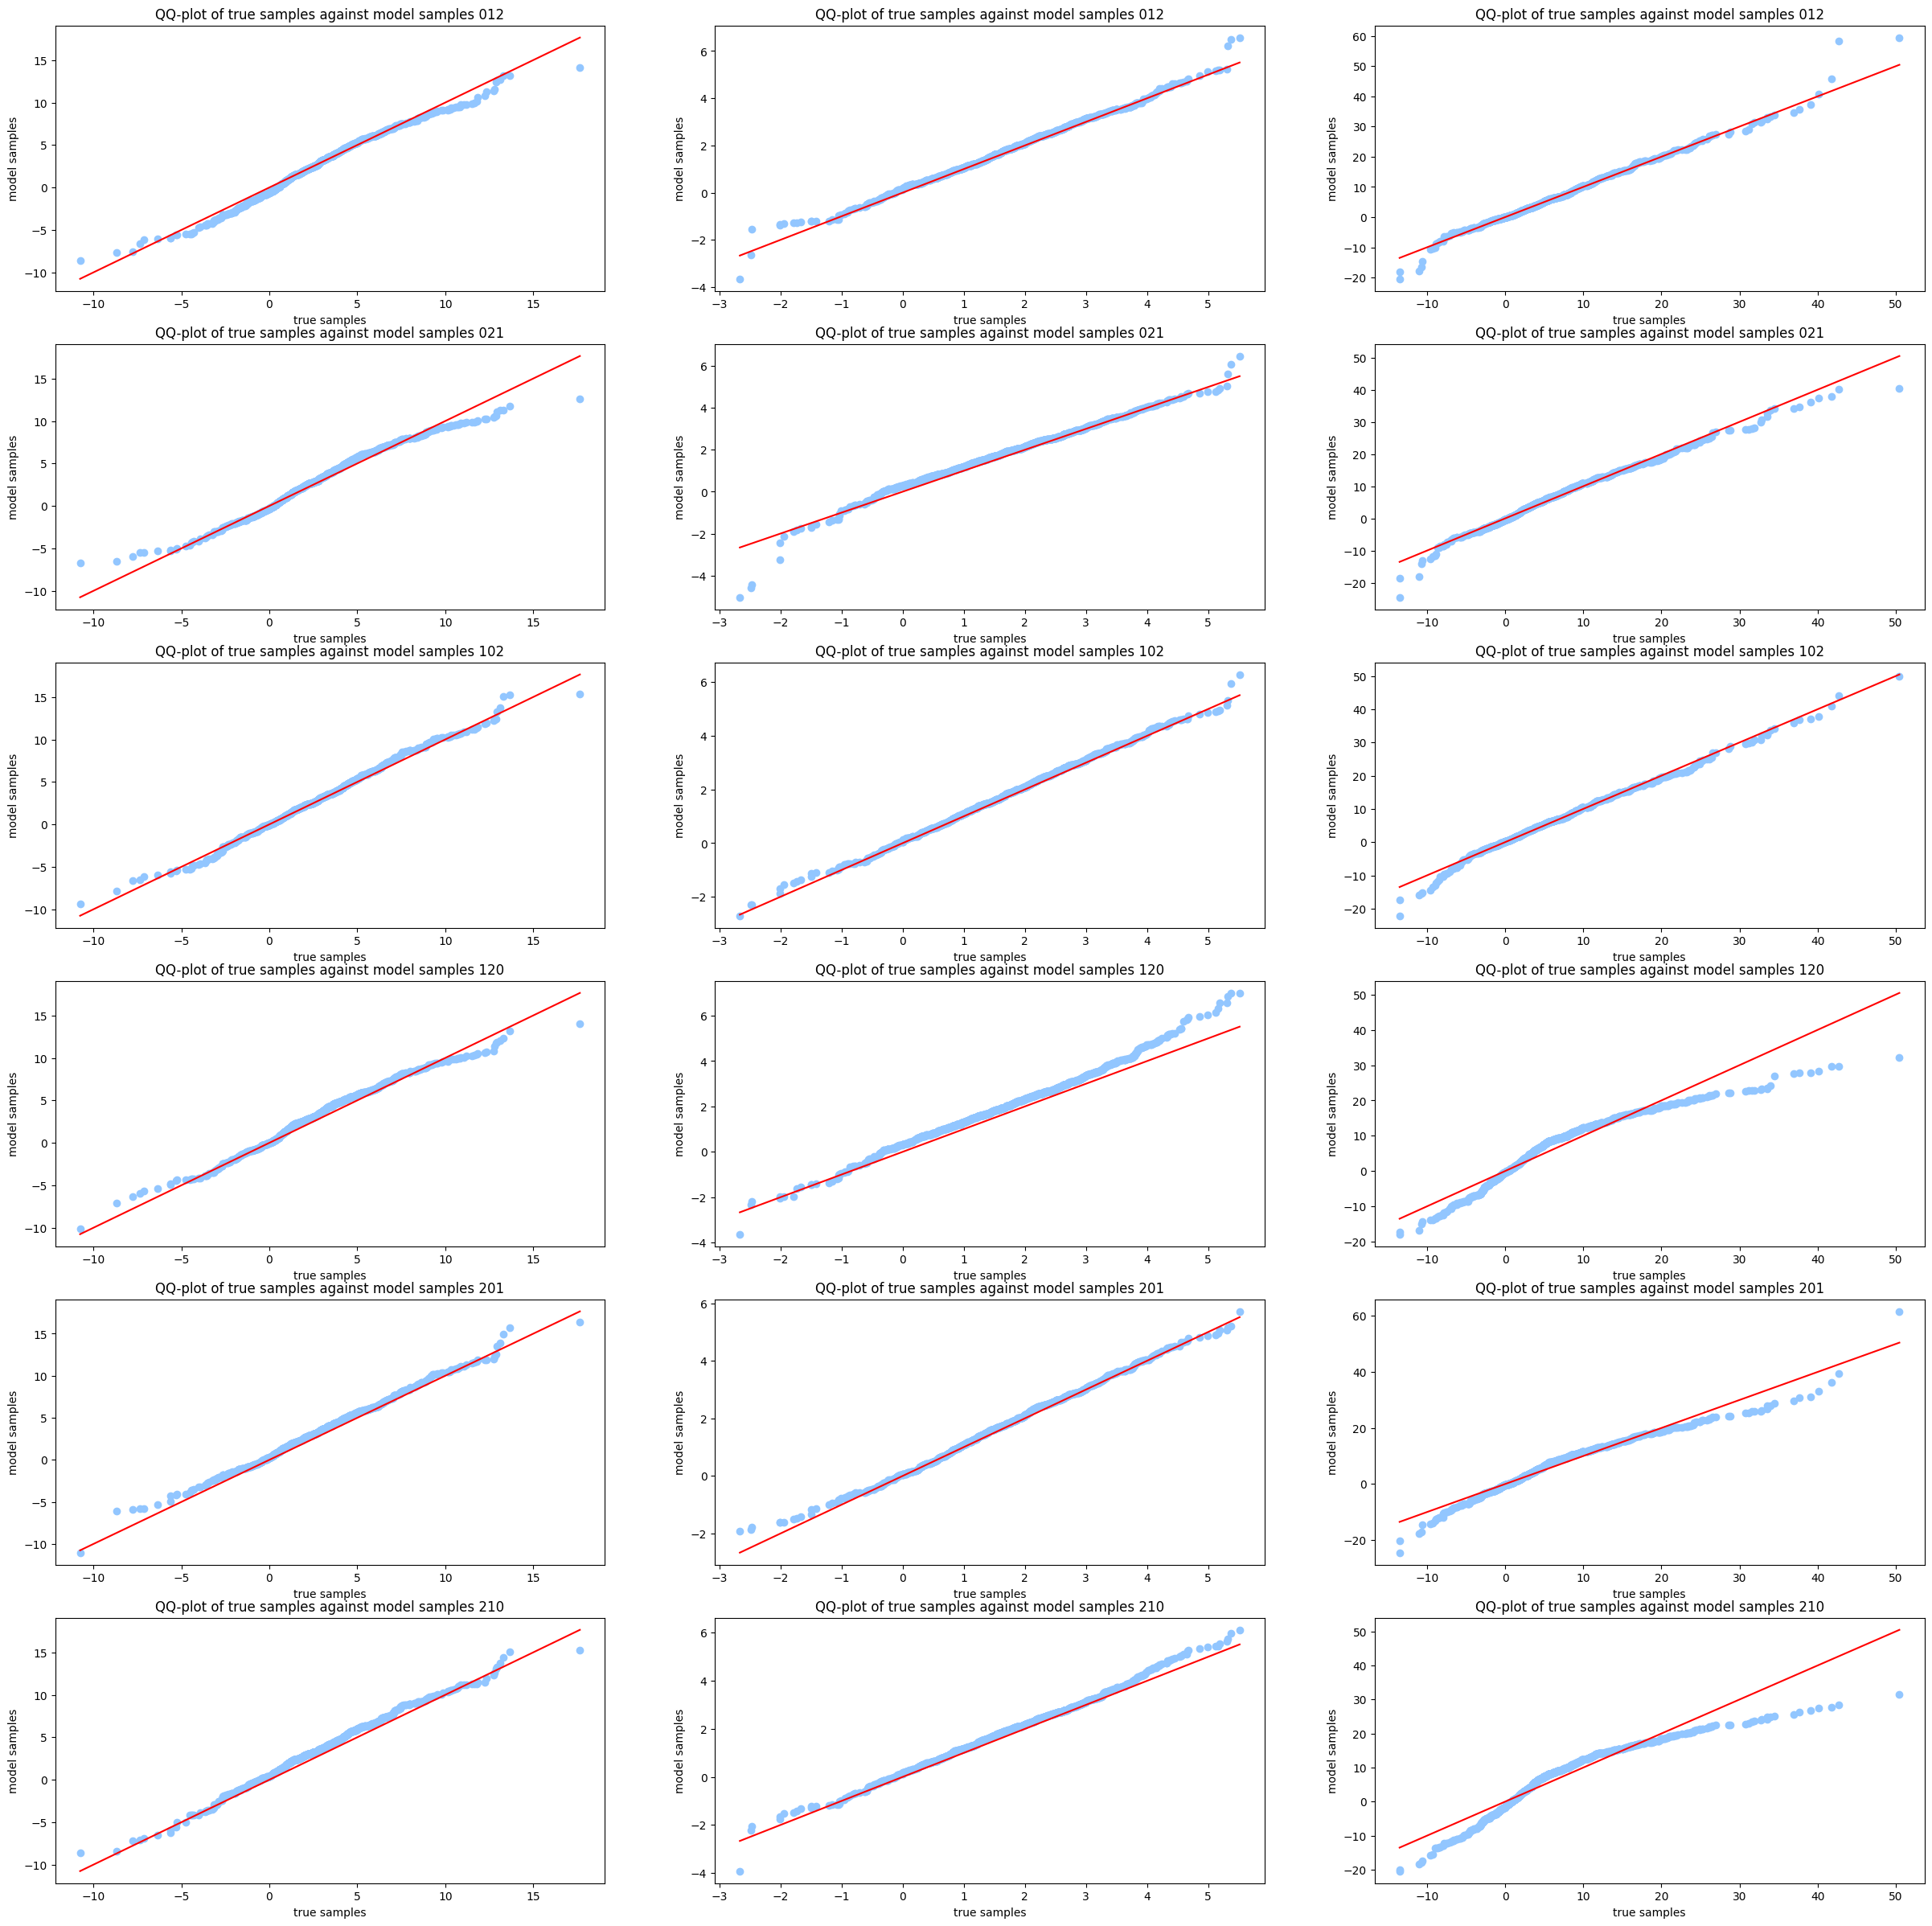

In [30]:
# create a figure with 18 subplots with 6 rows and 3 columns
fig, axs = plt.subplots(6, 3, figsize=(30, 30))
# iterate over the rows
i = 0
for key, model in all_models.items():
    model.eval()
    
    order = [int(x) for x in key]
    # create a permutation matrix from the order
    permutation_matrix = torch.zeros((3, 3))
    for i_, j_ in enumerate(order):
        permutation_matrix[i_, j_] = 1
    
    with torch.no_grad():
        model_samples = model.sample(1000, perm_mat=permutation_matrix).cpu().numpy()
        # iterate over the columns
        for j in range(3):
            true_samples = dset_sinusoidal.samples[j].values
            # create a qqplot of the true samples against the model samples by first sorting them
            model_samples_sorted = np.sort(model_samples[:, j])
            true_samples_sorted = np.sort(true_samples[:1000])
            axs[i, j].scatter(true_samples_sorted, model_samples_sorted, label="qqplot")
            # add title and x_label and y_label to the plot
            axs[i, j].set_title(f"QQ-plot of true samples against model samples {key}")
            axs[i, j].set_xlabel("true samples")
            axs[i, j].set_ylabel("model samples")
            # add an identity line to the plot
            axs[i, j].plot(
                [min(true_samples_sorted), max(true_samples_sorted)],
                [min(true_samples_sorted), max(true_samples_sorted)],
                label="identity",
                color='red'
            )
    i += 1
plt.show()

## Model training (Cubic)


In [14]:
all_models_cubic = {
    '012': None,
    '021': None,
    '102': None,
    '120': None,
    '201': None,
    '210': None,
}

for ordering in all_models_cubic.keys():
    order = [int(x) for x in ordering]
    all_models_cubic[ordering] = OSlow(
        in_features=3,
        layers=[10, 10],
        dropout=None,
        residual=False,
        activation=torch.nn.LeakyReLU(),
        additive=False,
        num_transforms=1,
        # TODO: fix this
        normalization=ActNorm,
        base_distribution=torch.distributions.Normal(loc=0, scale=1),
        ordering=torch.IntTensor(order),
    )
  

training model 012:   0%|          | 0/100 [00:00<?, ?it/s]

training model 210: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


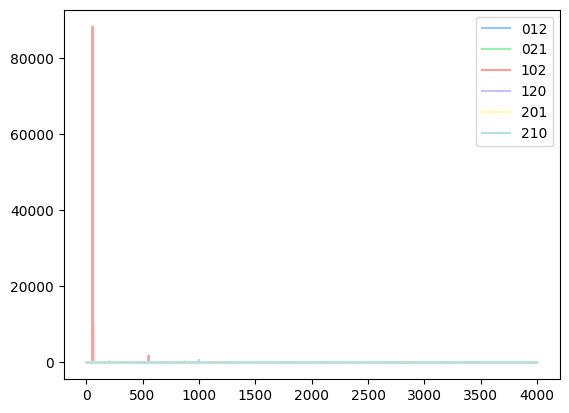

In [15]:
# create a torch dataset and dataloader from dset.samples
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
tensor_samples = torch.tensor(dset_cubic.samples.values).float()
torch_dataset = TensorDataset(tensor_samples)
torch_dataloader = DataLoader(torch_dataset, batch_size=256, shuffle=True)
epoch_count = 100
all_histories_cubic = {}
for key, model in all_models_cubic.items():
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)

    all_histories_cubic[key] = []
    progress_bar = tqdm(range(epoch_count), desc="training model {}".format(key))

    for epoch in progress_bar:
        for batch, in torch_dataloader:
            batch = batch.to(device)
            loss = -model.log_prob(batch).mean()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.step()
            all_histories_cubic[key].append(loss.item())
    plt.plot(all_histories_cubic[key], label=key)
plt.legend()
plt.show()

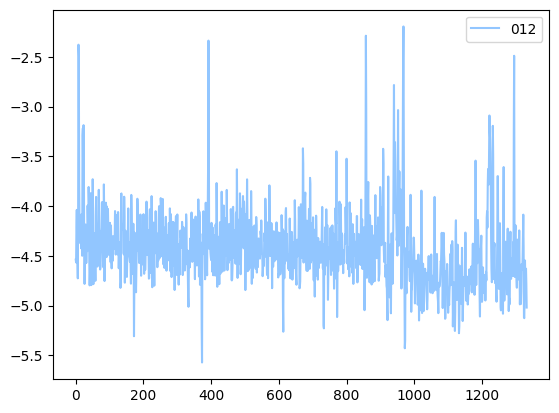

In [18]:
smoothed_histories = smooth_graph(all_histories_cubic, window_size=1)
for key in all_histories_cubic.keys():
    plt.plot(smoothed_histories[key][2 * len(smoothed_histories[key])//3:], label=key)
plt.legend()
plt.show()

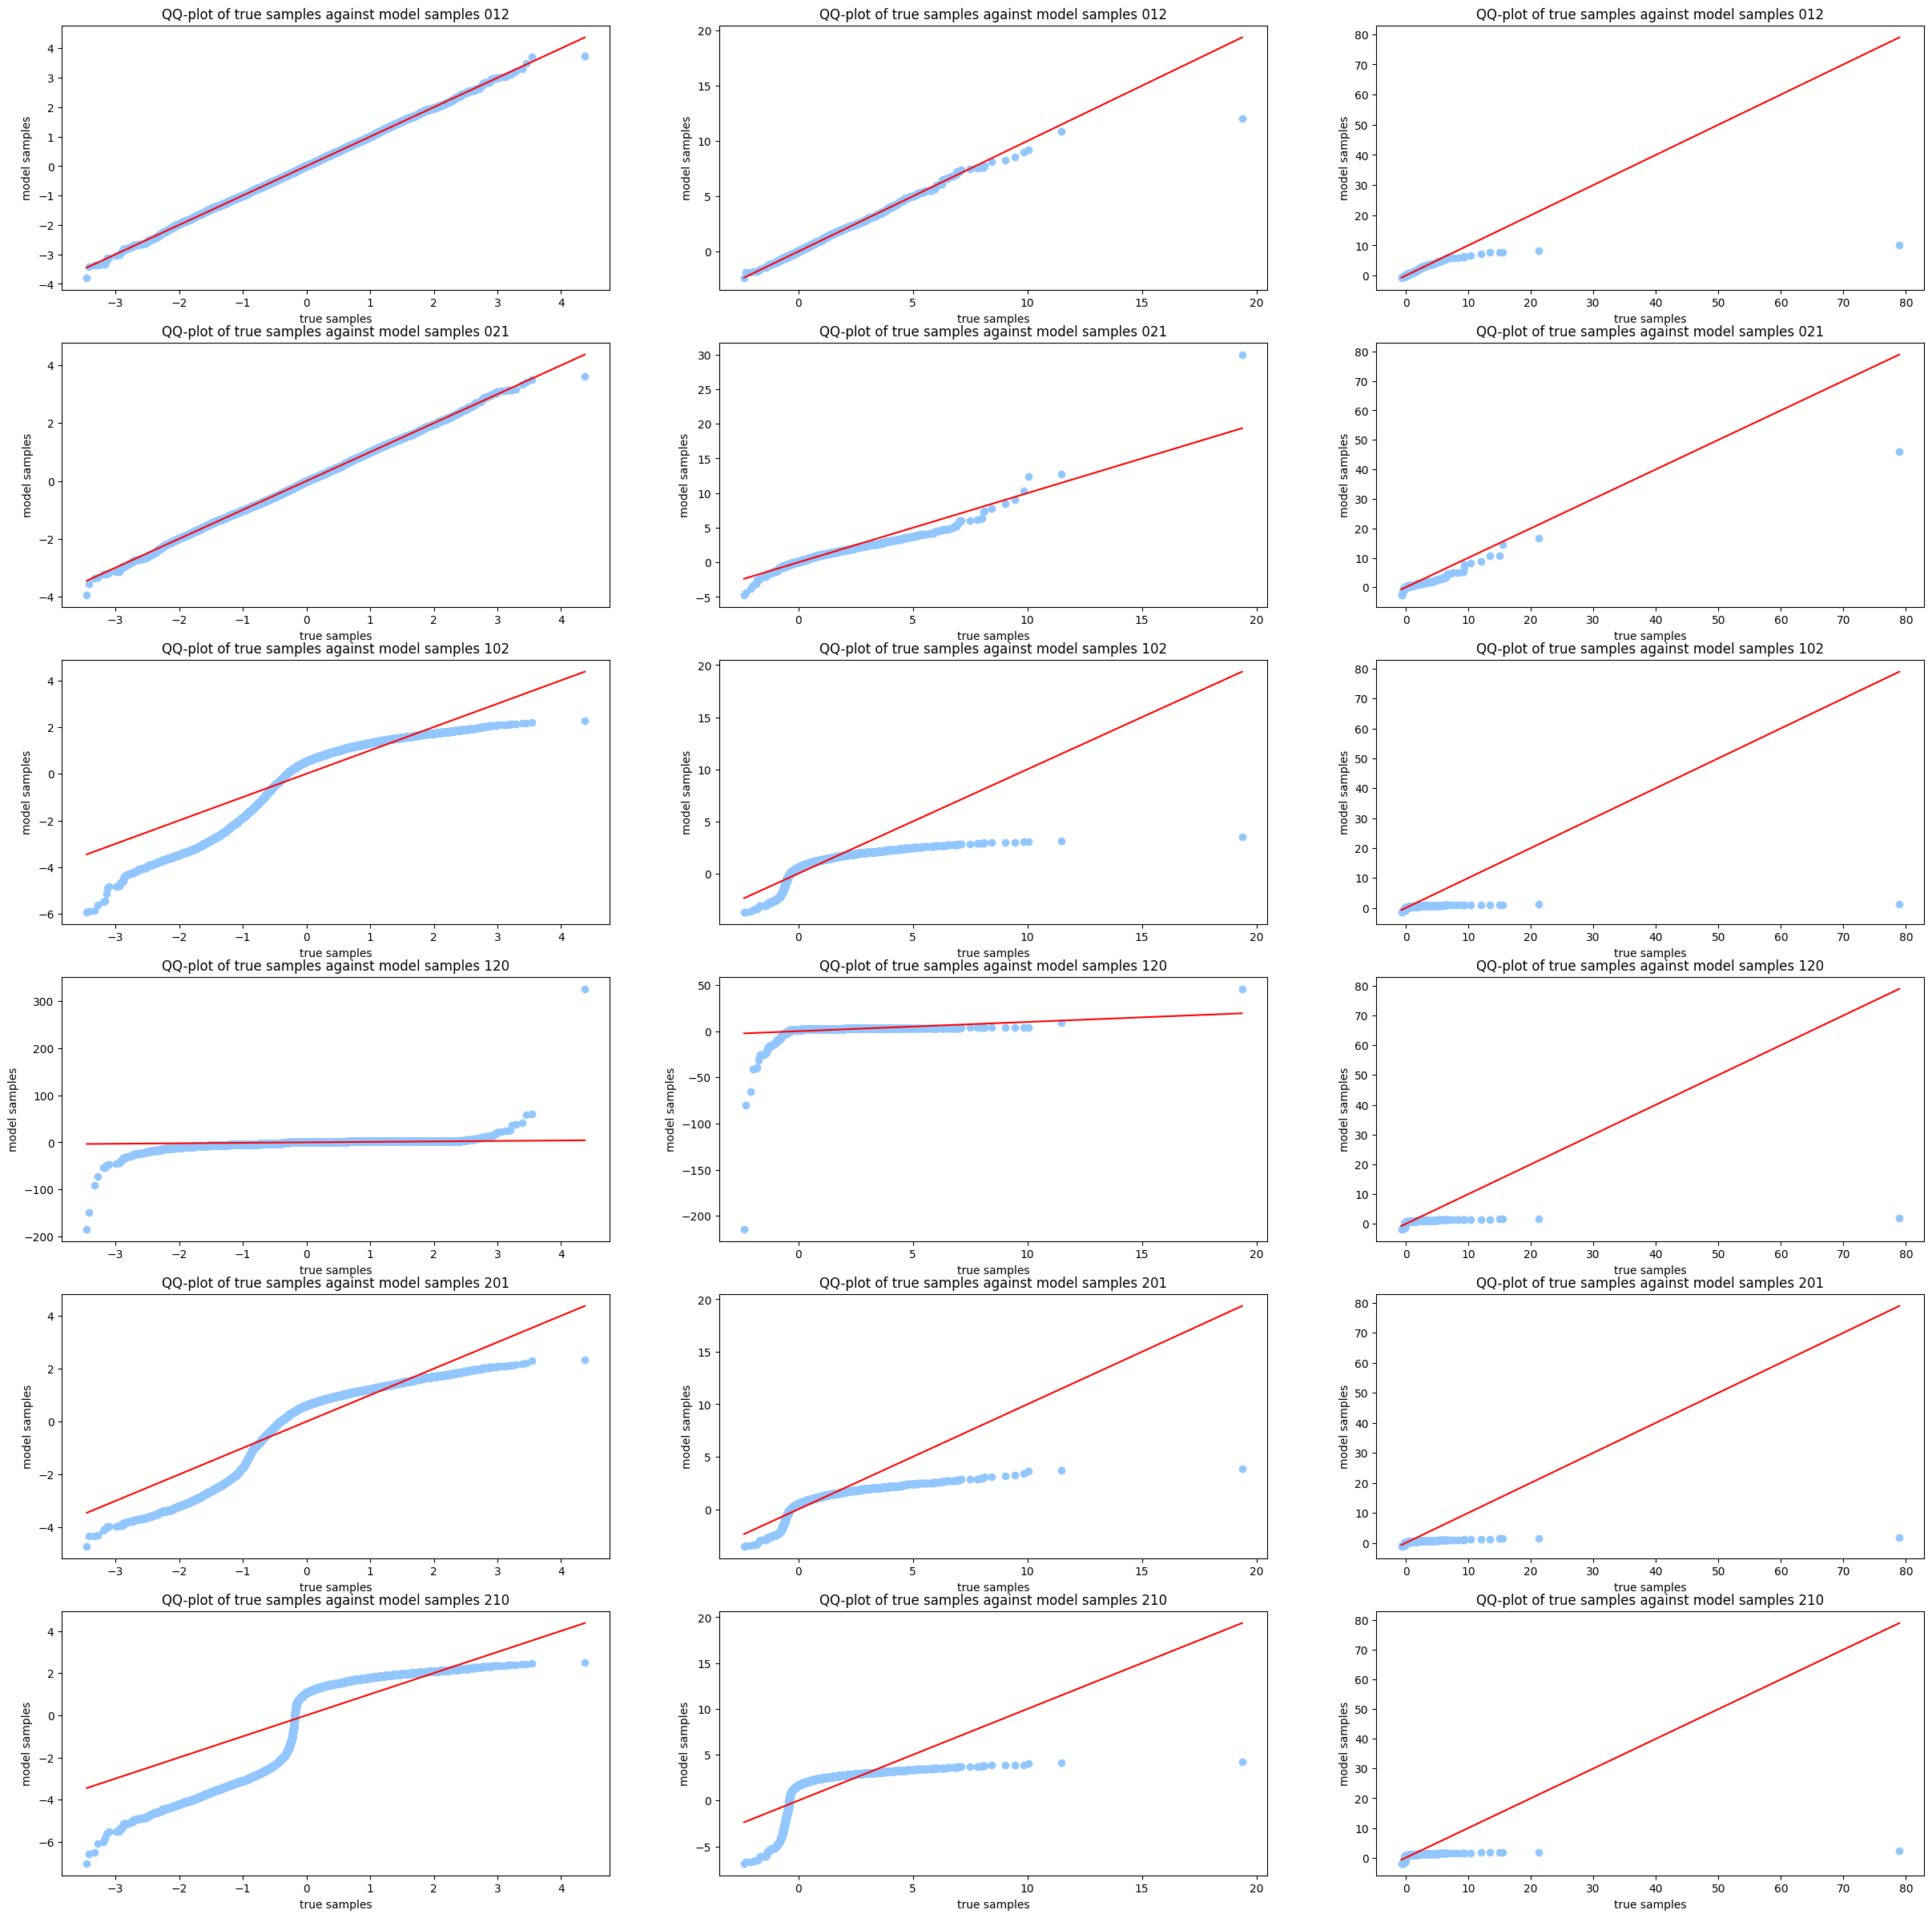

In [17]:
# create a figure with 18 subplots with 6 rows and 3 columns
fig, axs = plt.subplots(6, 3, figsize=(30, 30))
# iterate over the rows
i = 0
for key, model in all_models_cubic.items():
    model.eval()
    with torch.no_grad():
        model_samples = model.sample(10000).cpu().numpy()
        # iterate over the columns
        for j in range(3):
            true_samples = dset_cubic.samples[j].values
            # create a qqplot of the true samples against the model samples by first sorting them
            model_samples_sorted = np.sort(model_samples[:, j])
            true_samples_sorted = np.sort(true_samples)
            axs[i, j].scatter(true_samples_sorted, model_samples_sorted, label="qqplot")
            # add title and x_label and y_label to the plot
            axs[i, j].set_title(f"QQ-plot of true samples against model samples {key}")
            axs[i, j].set_xlabel("true samples")
            axs[i, j].set_ylabel("model samples")
            # add an identity line to the plot
            axs[i, j].plot(
                [min(true_samples_sorted), max(true_samples_sorted)],
                [min(true_samples_sorted), max(true_samples_sorted)],
                label="identity",
                color='red'
            )
    i += 1
plt.show()